In [1]:
from glob import glob
import sys, scipy
from scipy.stats import chi2, poisson

import matplotlib.pyplot as plt
import numpy as np

In [2]:
import ROOT as rt
import root_numpy as rtnp

Welcome to JupyROOT 6.12/06


In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [4]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

Using TensorFlow backend.


# Get the samples

In [5]:
hlf_features = ['HT', 'MET', 'PhiMET', 'MT', 'nJets', 'bJets',
                'allJetMass', 'LepPt', 'LepEta', 'LepPhi', 'LepIsoCh',
                'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 'LepIsEle', 'nMu',
                'allMuMass', 'allMuPt', 'nEle', 'allEleMass', 'allElePt', 'nChHad',
                'nNeuHad', 'nPhoton']

active_hlf_features = ['HT', 'MET', 'MT', 'allJetMass',
                       'allMuPt',
                       'allElePt',
                       'LepPt', 'LepEta', 'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu',
                       
                       'LepCharge','LepIsEle', 
                       
                       'nMu', 'nJets', 'bJets', 'nEle', 'nChHad', 'nNeuHad', 'nPhoton']

N_binomial_features = 2
N_poisson_features = 7

In [6]:
sel = []
for a in active_hlf_features:
    for i,f in enumerate(hlf_features):
        if a == f:
            sel.append(i)

print 'Activated HLF:'
for n in np.array(hlf_features)[sel]:
    print '\t', n

Activated HLF:
	HT
	MET
	MT
	allJetMass
	allMuPt
	allElePt
	LepPt
	LepEta
	LepIsoCh
	LepIsoGamma
	LepIsoNeu
	LepCharge
	LepIsEle
	nMu
	nJets
	bJets
	nEle
	nChHad
	nNeuHad
	nPhoton


In [7]:
data_folder = '../data/'

raw_sample = {}
l = np.zeros(3)
for i,n in enumerate(['ttbar', 'Wlnu', 'qcd']):
    raw_sample[n] = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
    l[i] = raw_sample[n].shape[0]
    
i = int(np.min(l)*0.7)
N_train = i - i%50000
print 'Train sample of', N_train

N_val = int(np.min(l)) - N_train
N_val -= N_val%10000
print 'Validation sample of', N_val

x_train = np.zeros((0,len(sel)))
for s in raw_sample.values():
    x_train = np.concatenate((x_train, s[:N_train, sel]))

print 'Train data shape: ', x_train.shape

x_val = np.zeros((0,len(sel)))
for s in raw_sample.values():
    x_val = np.concatenate((x_val, s[ N_train : N_train+N_val, sel]))
    
print 'Validation data shape: ', x_val.shape

Train sample of 800000
Validation sample of 360000
Train data shape:  (2400000, 20)
Validation data shape:  (1080000, 20)


In [8]:
samples_name = ['Wlnu','qcd', 'ttbar']
trigger_rate = np.array([440., 251., 2.51])
fraction = trigger_rate/ np.sum(trigger_rate)

x_test = np.zeros((0,len(sel)))
y_test = np.zeros(0)
size = np.zeros(len(samples_name))
for label, s in raw_sample.iteritems():
    x_test = np.concatenate((x_test, s[N_train:, sel]))
    
    for i,l in enumerate(samples_name):
        if l == label:
            size[i] = s[N_train:].shape[0]
            y_test = np.concatenate(( y_test, i*np.ones(int(size[i])) ))
            break

w_test = dict(zip(samples_name, fraction/size))

Pre-processing

In [9]:
# PP_means = 0 #np.mean(x_train, axis=0)
# PP_std = 1 #np.std(x_train, axis=0)

# x_train = (x_train[:, sel]-PP_means)/PP_std
# x_train.shape

In [10]:
# # Cross-check tree
# import root_numpy as rtnp
# b_names = hlf_features + ['sample_label', 'train']

# arr_train = np.column_stack((x_train, l_train, np.ones_like(l_train)))
# arr_val = np.column_stack((x_val, l_val, np.zeros_like(l_val)))

# arr = np.concatenate((arr_train, arr_val))
# arr.dtype = zip(b_names,['<f8']*len(b_names))

# rtnp.array2root(arr, '/Users/olmo/cernbox/AnomalyDetection/data/_root/hlf_flat.root', treename='T', mode='RECREATE')

# Start the VAE declaration

In [11]:
original_dim = x_train.shape[1]
latent_dim = 4
intermediate_dim = 200
epsilon_std = 1.0
act_fun = 'sigmoid'

In [12]:
x_DNN_input = Input(shape=(original_dim,))
hidden_1 = Dense(intermediate_dim, activation=act_fun)(x_DNN_input)
hidden_2 = Dense(intermediate_dim, activation=act_fun)(hidden_1)
# hidden_3 = Dense(intermediate_dim, activation=act_fun)(hidden_2)
z_mean = Dense(latent_dim)(hidden_2)
z_log_var = Dense(latent_dim)(hidden_2)

In [13]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

z_latent_DNN = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [14]:
decoder_h1 = Dense(intermediate_dim, activation=act_fun)(z_latent_DNN)
decoder_h2 = Dense(intermediate_dim, activation=act_fun)(decoder_h1)
# decoder_h3 = Dense(intermediate_dim, activation=act_fun)(decoder_h2)
x_decoded_mean = Dense(original_dim)(decoder_h2)

# Need only 1 paramter to describe the last two HLF since are in {-1,+1}
x_decoded_log_var = Dense(original_dim - N_poisson_features - N_binomial_features)(decoder_h2)

Custom loss layer

In [15]:
kN = N_poisson_features + N_binomial_features
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)
    

    def vae_loss(self, x, x_decoded_mean, x_decoded_log_var):
        # Normal distribute variables
        norm_x = K.tf.divide(x[:,:-kN]-x_decoded_mean[:,:-kN], K.exp(x_decoded_log_var))
        single_NLL = 2*x_decoded_log_var + 0.5*K.square(norm_x)
        nll_loss = K.sum(single_NLL, axis=-1)
        
        #Binomial distributed variables
        i_st = -N_binomial_features - N_poisson_features
        p = 0.5*(1+0.98*K.tanh(x_decoded_mean[:, i_st : i_st + N_binomial_features]))
        n = x[:, i_st : i_st + N_binomial_features]
        nll_loss -= K.sum(K.tf.where(K.equal(n,1), K.log(p), K.log(1-p)), axis=-1)
        
#         p_1 = 0.5*(1+0.98*K.tanh(x_decoded_mean[:,-2 -N_poisson_features]))
#         p_2 = 0.5*(1+0.98*K.tanh(x_decoded_mean[:,-1 -N_poisson_features]))
#         nll_loss -= K.tf.where(K.equal(x[:,-2],1), K.log(p_1), -K.log(1-p_1))
#         nll_loss -= K.tf.where(K.equal(x[:,-1],1), K.log(p_2), -K.log(1-p_2))
        
        #Poisson distributed variables
        i_st = - N_poisson_features
        aux = x_decoded_mean[:, i_st:]
        mu = 1 + K.tf.where(K.tf.greater(aux, 0), aux, K.tf.divide(aux, K.sqrt(1+K.square(aux))))
#         mu = K.softplus(x_decoded_mean[:, i_st:])
#         mu = K.log(1 + K.exp(x_decoded_mean[:, i_st:]))
        n = x[:, i_st :]
        single_NLL = K.tf.lgamma(n+1) - n*K.log(mu) + mu
        nll_loss += K.sum(single_NLL, axis=-1)

        
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        # Wesserstrain distance (http://djalil.chafai.net/blog/2010/04/30/wasserstein-distance-between-two-gaussians/)
#         kl_loss = K.sum(K.square(z_mean) + K.exp(z_log_var) + 1 - 2*K.exp(z_log_var/2.), axis=-1)

        return K.mean(nll_loss + 2*kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        x_decoded_log_var = inputs[2]
        loss = self.vae_loss(x, x_decoded_mean, x_decoded_log_var)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return [x_decoded_mean, x_decoded_log_var]
    
y_VAEoutput = CustomVariationalLayer()([x_DNN_input, x_decoded_mean, x_decoded_log_var])

In [16]:
vae = Model(x_DNN_input, y_VAEoutput)
rms_prop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
vae.compile(optimizer='adam', loss=None)
print vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 200)          4200        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 200)          40200       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 4)            804         dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

# Training

In [17]:
fit_report = vae.fit(x_train,
        shuffle=True,
        epochs=100,
        batch_size=200,
        validation_data=(x_val, None),
        callbacks = [
                        EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=0.1),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_delta=0.3, verbose=1),
                        TerminateOnNaN()
            ])

Train on 2400000 samples, validate on 1080000 samples
Epoch 1/100
2400000/2400000 [==============================] - 100s 42us/step - loss: 205.0802 - val_loss: 61.7169
Epoch 2/100
2400000/2400000 [==============================] - 95s 40us/step - loss: 55.1957 - val_loss: 51.4389
Epoch 3/100
2400000/2400000 [==============================] - 98s 41us/step - loss: 50.4455 - val_loss: 48.6687
Epoch 4/100
2400000/2400000 [==============================] - 97s 40us/step - loss: 47.6593 - val_loss: 46.2107
Epoch 5/100
2400000/2400000 [==============================] - 97s 40us/step - loss: 47.1644 - val_loss: 42.0490
Epoch 6/100
2400000/2400000 [==============================] - 97s 40us/step - loss: 42.2357 - val_loss: 35.4490
Epoch 7/100
2400000/2400000 [==============================] - 96s 40us/step - loss: 43.3414 - val_loss: 42.0231
Epoch 8/100
2400000/2400000 [==============================] - 99s 41us/step - loss: 42.7940 - val_loss: 35.5953

Epoch 00008: ReduceLROnPlateau reducing

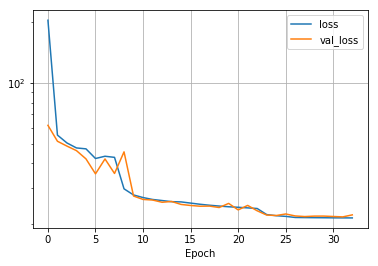

In [18]:
%matplotlib inline
for item in ['loss', 'val_loss']:
    plt.semilogy(np.array(fit_report.history[item][:]), label=item)
plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')

In [19]:
vae.save('last_saved_VAE.h5')

In [20]:
# if 0:
# from keras.models import load_model
# vae = load_model('last_saved_VAE.h5')
# print 'Loaded'

### Build encoder and decoder

In [21]:
encoder = Model(inputs=x_DNN_input, outputs=[z_mean, z_log_var])
encoder.save('saved_Encoder.h5')

In [22]:
# from keras.models import load_model
# aux = load_model('saved_Encoder.h5')
# aux.compile(optimizer='adam', loss='MSE')
# aux.predict(np.random(0,1,size=(10,22)))

In [23]:
# decoder_input = Input(shape=(latent_dim,))
# _h1_decoded = decoder_h1(decoder_input)
# _h_decoded = decoder_h(_h1_decoded)
# _x_decoded_mean = decoder_mean(_h_decoded)
# _x_decoded_log_var = decoder_log_var(_h_decoded)
# decoder = Model(decoder_input, [_x_decoded_mean, _x_decoded_log_var])
# decoder.save('saved_Decoder.h5')

# Validation

Gather the signal data

In [24]:
data_folder = '../data/'

BSM_samples = ['AtoChHW', 'AtoChHW_HIGHMASS', 'Ato4l', 'Zprime', 'Wprime']

x_sig = {}
for n in BSM_samples:
    s = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
    x_sig[n] = s[:, sel]

### Predict latent space

In [25]:
x_test_encoded = np.array(encoder.predict(x_test))

x_sig_encoded = {}
for k,v in x_sig.iteritems():
    print k
    x_sig_encoded[k] = np.array(encoder.predict(v))

Zprime
Ato4l
AtoChHW_HIGHMASS
Wprime
AtoChHW


Latent space mean distribution

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


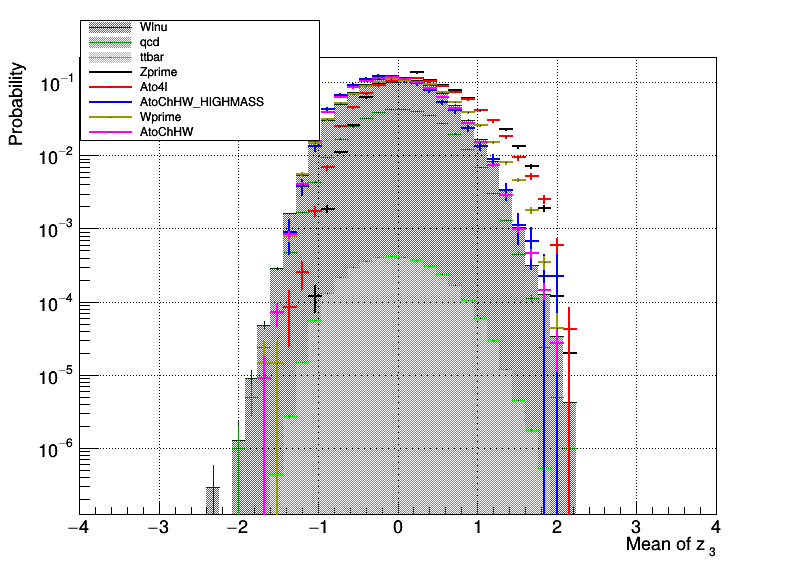

In [46]:
histos = []
latent_dim = 3
binning = [50, -4, 4]

c = rt.TCanvas('c', 'c', 800, 600)

for i in range(len(w_test)):
    h = rt.TH1F('hSM{}'.format(i), samples_name[i], binning[0], binning[1], binning[2])
    for j in range(i, len(w_test)):
        z = x_test_encoded[0, y_test == j, latent_dim]
        rtnp.fill_hist(h, z, weights=w_test[samples_name[j]]*np.ones_like(z))
    
    h.SetStats(0)
    h.SetLineColor(rt.kGreen+4-2*i)
    h.SetFillColorAlpha(rt.kGreen+4-2*i, 0.7)
    h.SetFillStyle(3001)
    h.Draw('Bar SAME')
    histos.append(h)
    
    
colors = [1,2,4,rt.kYellow+2,6,7]
# fill
for i, n in enumerate(x_sig.keys()):
    h = rt.TH1F('hBSM{}'.format(i), n, binning[0], binning[1], binning[2])
    z = x_sig_encoded[n][0, :, latent_dim]
    rtnp.fill_hist(h, z, weights=1/float(z.shape[0])*np.ones_like(z))

    h.SetStats(0)
    h.SetLineColor(colors[i])
    h.SetLineWidth(2)
    h.Draw('SAME')
    histos.append(h)

c.BuildLegend()
histos[0].SetTitle('')
histos[0].SetXTitle('Mean of z_{'+str(latent_dim)+'}')
histos[0].SetYTitle('Probability')
c.SetGrid()
c.SetLogy()
c.Draw()

## Recostruction sum of pdf

In [27]:
def sum_of_gaussians(x, mu_vec, sigma_vec):
    x = np.atleast_2d(x)
    if x.shape[0] <= x.shape[1]:
        x = x.T
    x_norm = (x - mu_vec)/sigma_vec
    single_gaus_val = np.exp(-0.5*np.square(x_norm))/(sigma_vec*np.sqrt(2*np.pi))
    return np.sum(single_gaus_val, axis=1)/mu_vec.shape[0]

In [28]:
def sum_of_possion(x_in, mu_vec):
    out = np.zeros_like(x_in)
    for i, aux in enumerate(x_in):
        out[i] = np.sum(poisson.pmf(aux, mu_vec))
    return out

HT
MET
MT
allJetMass
allMuPt
allElePt
LepPt
LepEta
LepIsoCh
LepIsoGamma
LepIsoNeu
LepCharge
LepIsEle
nMu
nJets
bJets
nEle
nChHad
nNeuHad
nPhoton


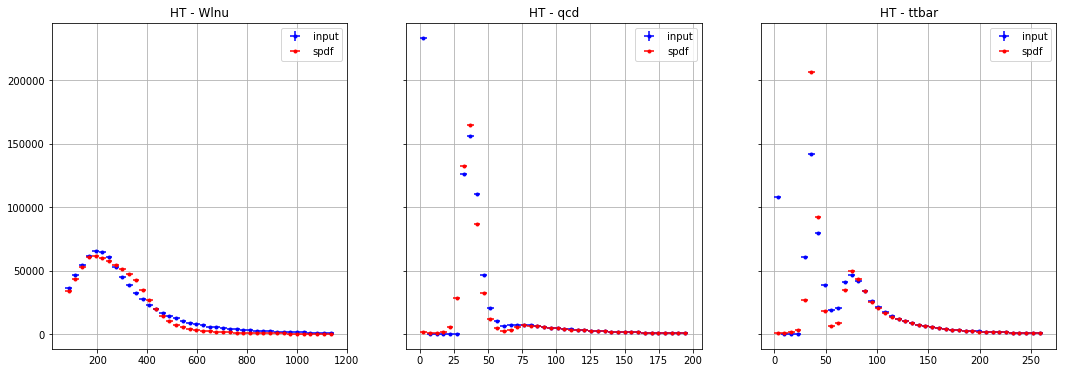

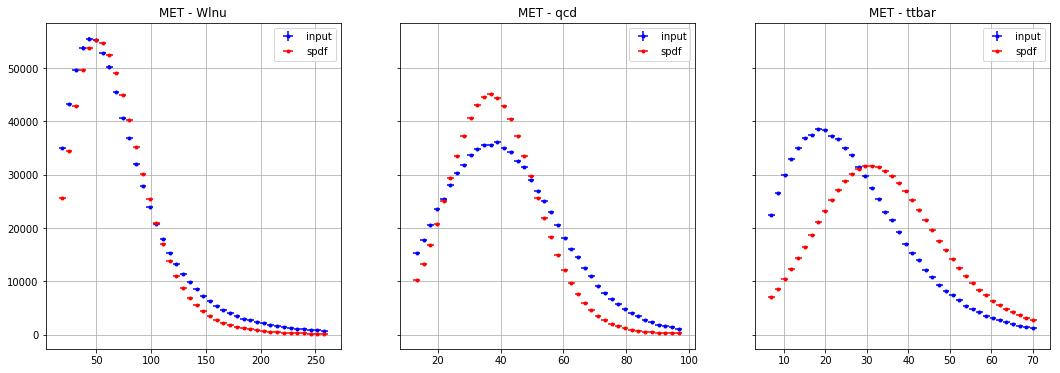

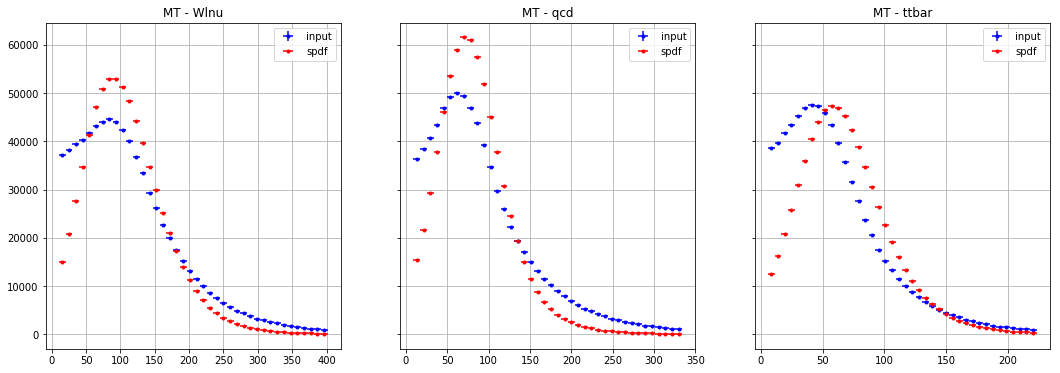

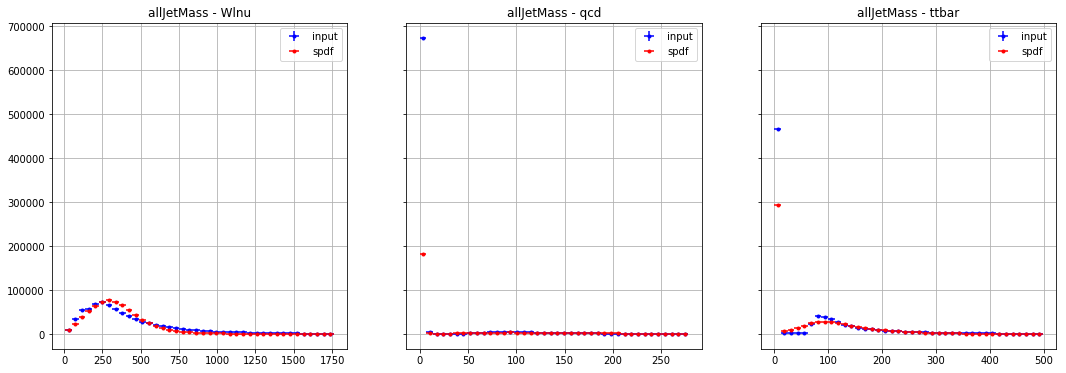

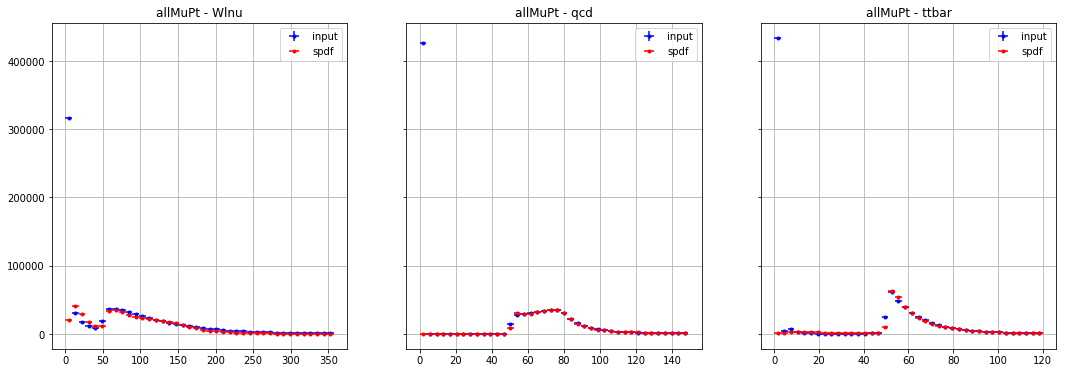

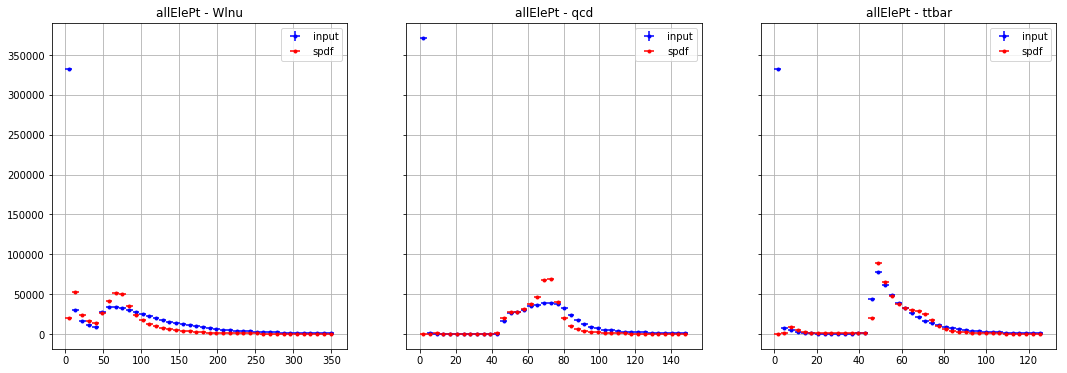

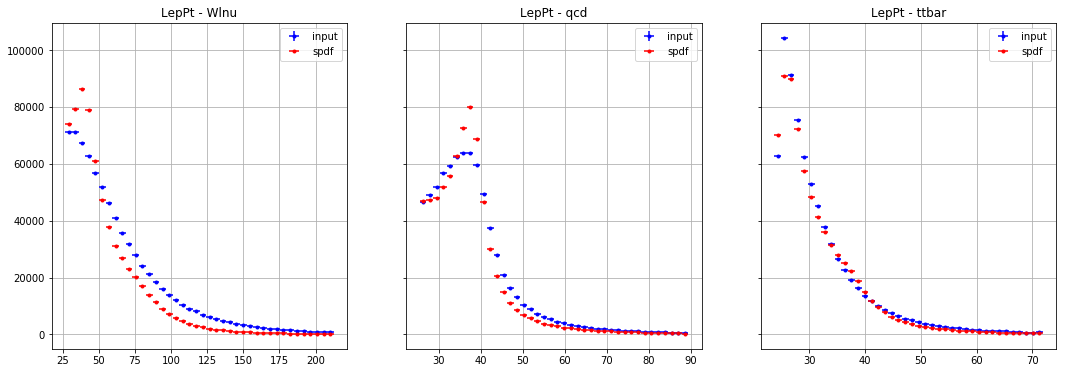

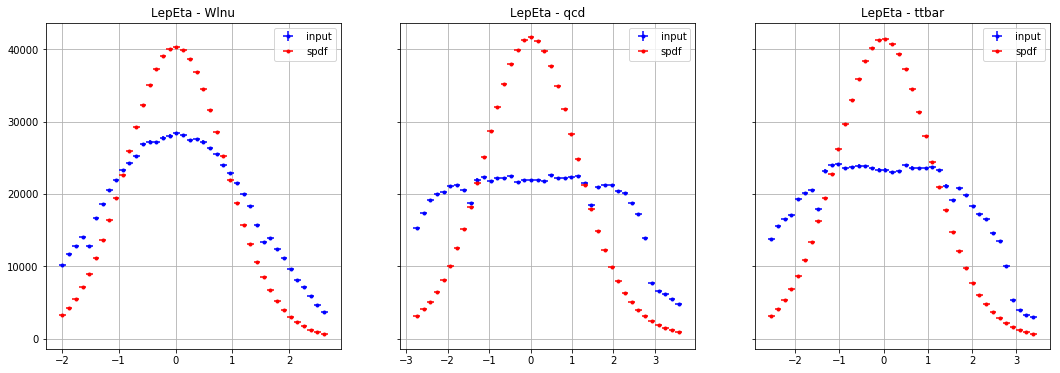

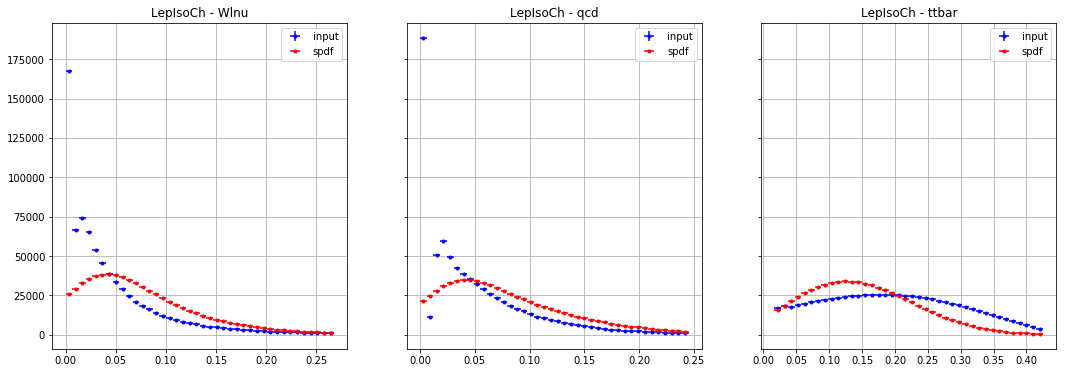

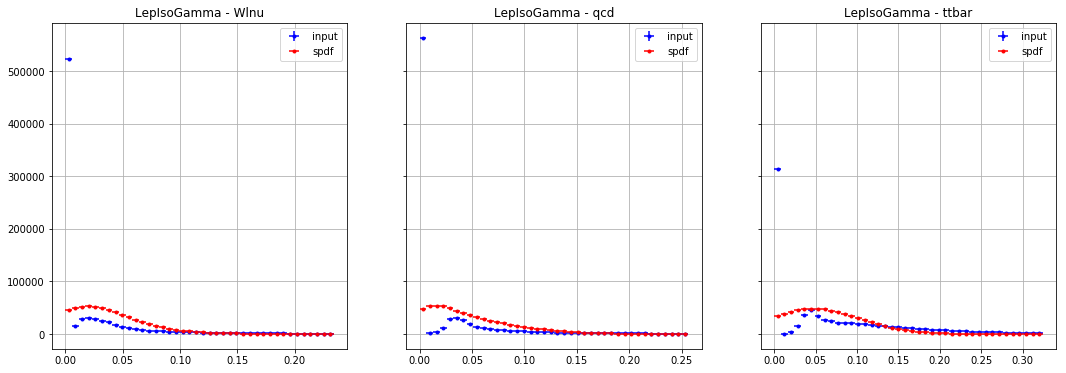

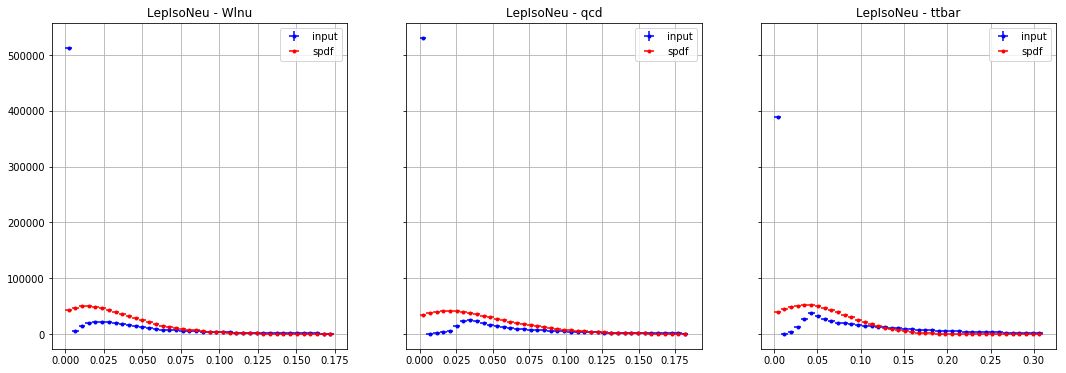

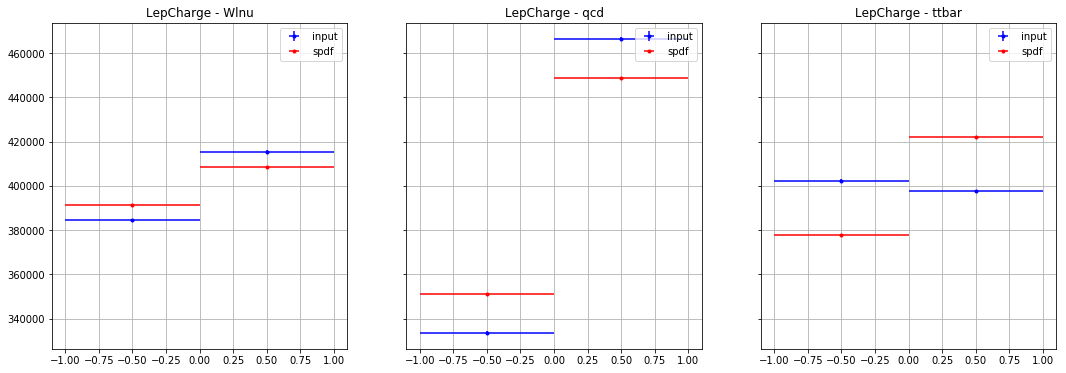

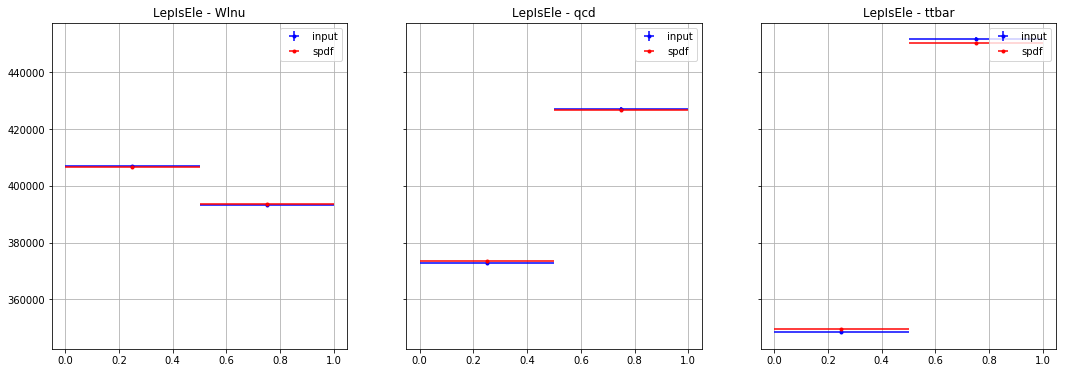

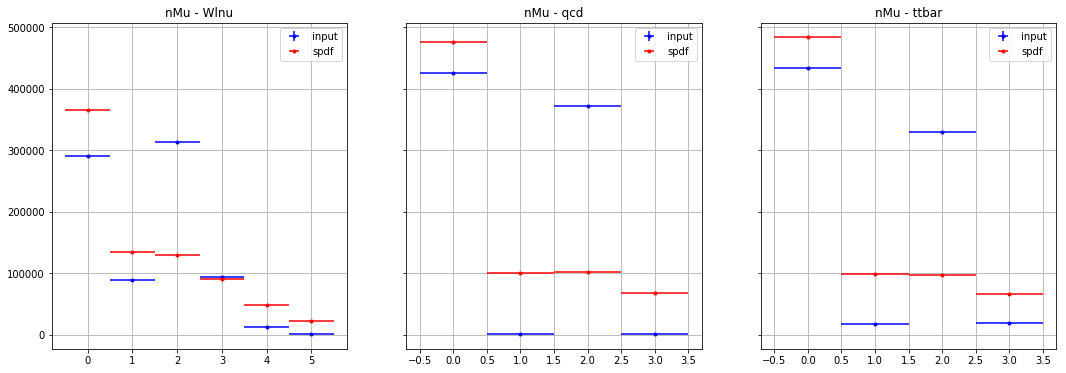

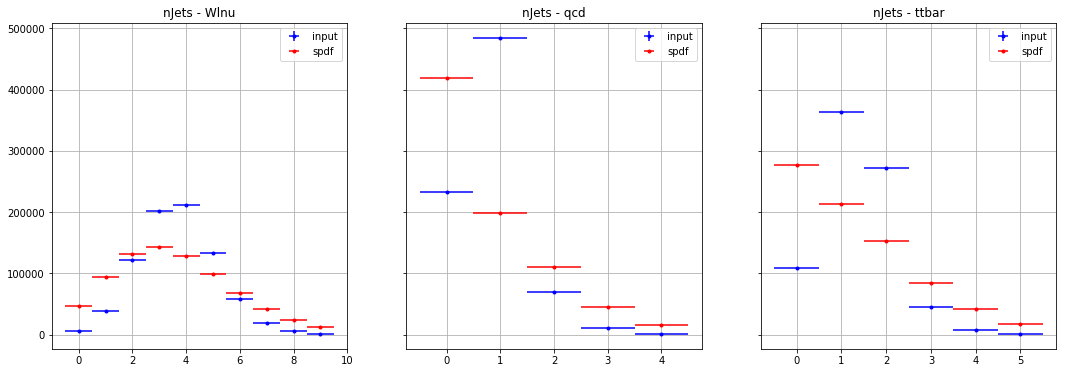

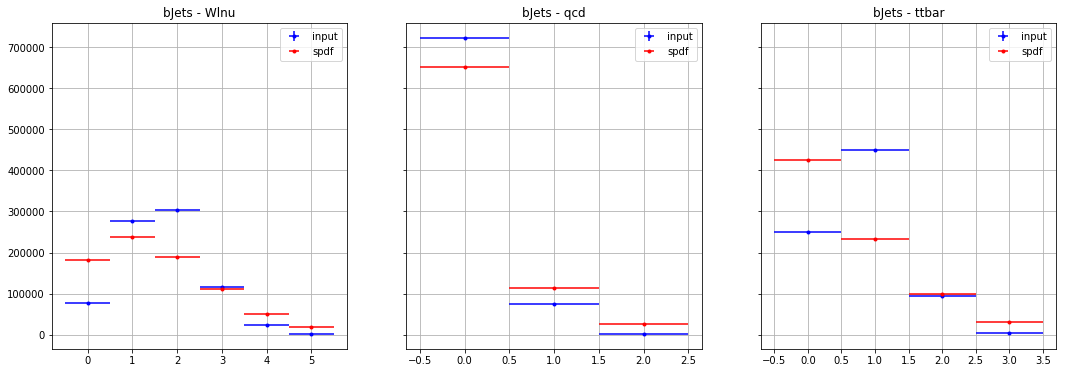

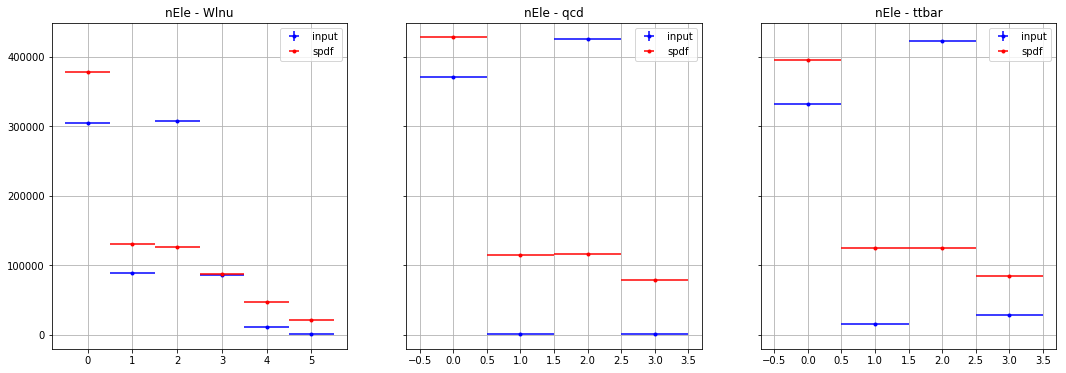

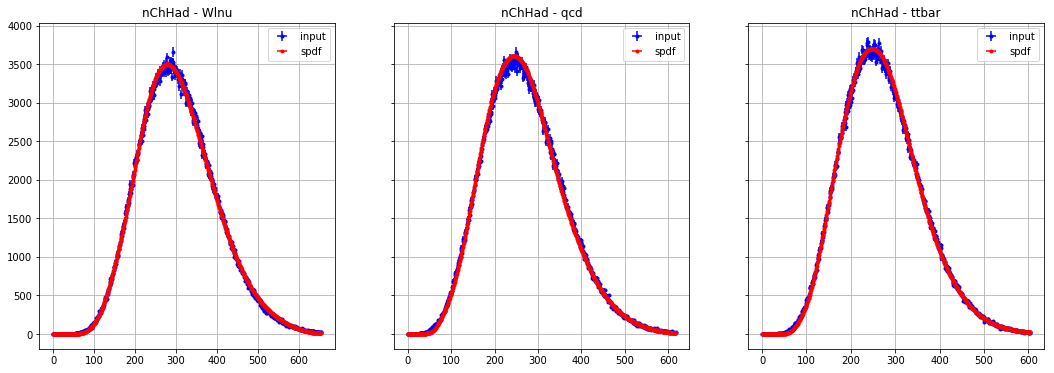

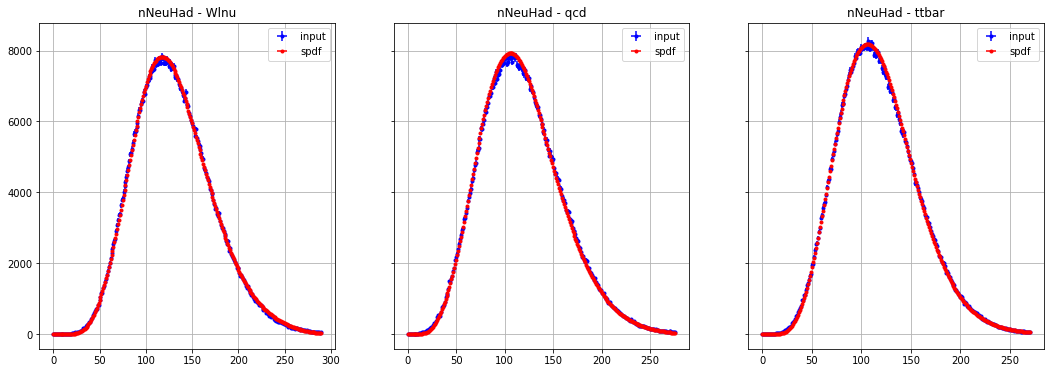

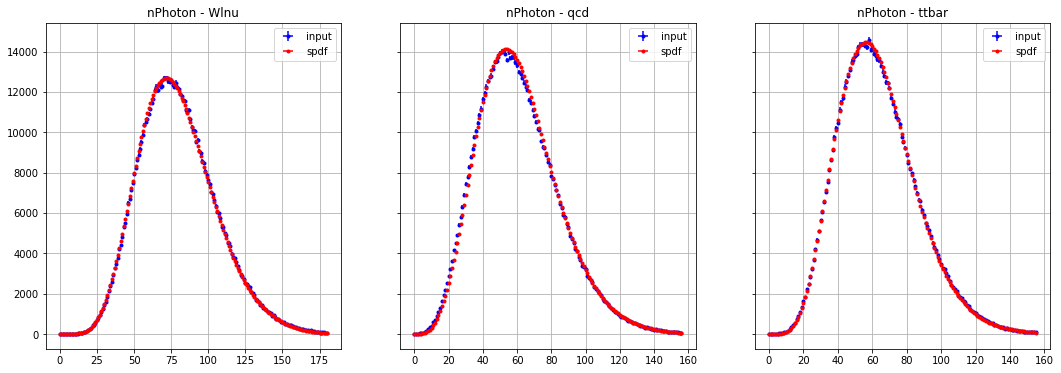

In [29]:
x_autoencoded_pars = vae.predict(x_train)

for i,hlf_name in enumerate(active_hlf_features):
    f, ax_arr = plt.subplots(1,len(samples_name), figsize=(18,6), sharey=True)
    print hlf_name
#     plt.yscale('log', nonposy='clip')
    for k, sample in enumerate(samples_name):
        #Plot distribution of the variable
        x_aux = x_train[N_train*k: N_train*(k+1), i]
        
        if i<len(active_hlf_features) - N_poisson_features - N_binomial_features:
            histo_range = (np.percentile(x_aux, 5.), np.percentile(x_aux, 99.))
            bin_content, bin_edges = np.histogram(x_aux, bins=40, range=histo_range)
            bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
            bin_width = bincenters[1]-bincenters[0]
            
            mu_vec = x_autoencoded_pars[0][N_train*k: N_train*(k+1), i]
            sigma_vec = np.exp(x_autoencoded_pars[1][N_train*k: N_train*(k+1), i])
            spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_gaussians(bincenters, mu_vec, sigma_vec)
#             print np.sum(bin_content)
        elif i < len(active_hlf_features) - N_poisson_features:
            bin_content, bin_edges = np.histogram(x_aux, bins=2, range=(np.min(x_aux), np.max(x_aux)))
            bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
            bin_width = bincenters[1]-bincenters[0]
            p = 0.5*(1+0.98*np.tanh(x_autoencoded_pars[0][N_train*k: N_train*(k+1), i]))
            
            spdf_bin_content = np.zeros_like(bincenters)
            spdf_bin_content[np.nonzero(bin_content)[0][1]] = np.sum(p)
            spdf_bin_content[np.nonzero(bin_content)[0][0]] = np.sum(1-p)
        else:
            Nmax = int(np.percentile(x_aux, 99.9))
            bin_content, bin_edges = np.histogram(x_aux, bins=Nmax+1, range=(-0.5, Nmax+0.5))
            bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
            bin_width = bincenters[1]-bincenters[0]
            aux = x_autoencoded_pars[0][N_train*k: N_train*(k+1), i]
            mu_vec = 1 + np.where(np.greater(aux, 0), aux, np.divide(aux, np.sqrt(1+np.square(aux))))
            spdf_bin_content = sum_of_possion(bincenters, mu_vec)
            
        
        ax_arr[k].errorbar(bincenters, bin_content, xerr=bin_width/2., yerr=np.sqrt(bin_content), fmt='.b', label='input')
        ax_arr[k].errorbar(bincenters, spdf_bin_content, xerr=bin_width/2., fmt='.r', label='spdf')
        ax_arr[k].grid()
        ax_arr[k].set_title(hlf_name + ' - ' + sample)        
        ax_arr[k].legend(loc='best')
        
plt.show()

# Test Statistics with Losses

In [30]:
from scipy.special import loggamma

In [31]:
def numpy_loss(x, x_encoded, x_decoded):
    x_decoded_mean = x_decoded[0]
    x_decoded_log_var = x_decoded[1]
    
    z_mean = x_encoded[0]
    z_log_var = x_encoded[1]
    
    # Normal distribute variables
    norm_x = np.divide(x[:,:-kN]-x_decoded_mean[:,:-kN], np.exp(x_decoded_log_var))
    single_NLL = 2*x_decoded_log_var + 0.5*np.square(norm_x)
    nll_loss = np.sum(single_NLL, axis=-1)

    #Binomial distributed variables
    i_st = -N_binomial_features - N_poisson_features
    p = 0.5*(1+0.98*np.tanh(x_decoded_mean[:, i_st : i_st + N_binomial_features]))
    n = x[:, i_st : i_st + N_binomial_features]
    nll_loss -= np.sum(np.where(np.equal(n,1), np.log(p), np.log(1-p)), axis=-1)

    #Poisson distributed variables
    i_st = - N_poisson_features
#     mu = np.log(1 + np.exp(x_decoded_mean[:, i_st:]))
    aux = x_decoded_mean[:, i_st:]
    mu = 1 + np.where(np.greater(aux, 0), aux, np.divide(aux, np.sqrt(1+np.square(aux))))
    n = x[:, i_st :]
    single_NLL = loggamma(n+1) - n*np.log(mu) + mu
    nll_loss += np.sum(single_NLL, axis=-1)

    kl_loss = - 0.5 * np.sum(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var), axis=-1)
    return [nll_loss + 2*kl_loss, nll_loss, kl_loss]

Create the samples

In [32]:
x_test_decoded = vae.predict(x_test)

x_sig_decoded = {}
for n in x_sig.keys():
    x_sig_decoded[n] = vae.predict(x_sig[n])

In [33]:
loss_test = numpy_loss(x_test, x_test_encoded, x_test_decoded)

loss_sig = {}
for n in x_sig.keys():
    loss_sig[n] = numpy_loss(x_sig[n], x_sig_encoded[n], x_sig_decoded[n])

In [34]:
def weighted_quantiles(arr, weights, q):
    
    normalize_weights = np.sqrt(np.max(weights)*np.min(weights))
    print np.max(weights)
    print np.min(weights)
    print normalize_weights
    weights /= normalize_weights
    print weights
    
    ind_sorted = np.argsort(arr)
    sorted_arr = arr[ind_sorted]
    sorted_weights = weights[ind_sorted]
    print sorted_weights
    plt.hist(sorted_weights)
    
    Sn = np.cumsum(sorted_weights)
    Pn = Sn/np.sum(sorted_weights)
    
    return np.interp(q, Pn, sorted_arr), Sn, Pn

0.999994529773
0.999995529769
0.999995242201
0.999995242201
0.999995242201
0.999995242201
0.999995242201
0.999995242201
0.999995242201
0.999995242201
0.999994954634
0.999994665424
0.999994663781
0.99999465721
0.99999465721
0.999993668865
1692.56206306
Zprime : 1.93e-03
Ato4l : 4.19e-03
AtoChHW_HIGHMASS : 2.23e-04
Wprime : 7.29e-04
AtoChHW : 1.78e-05


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


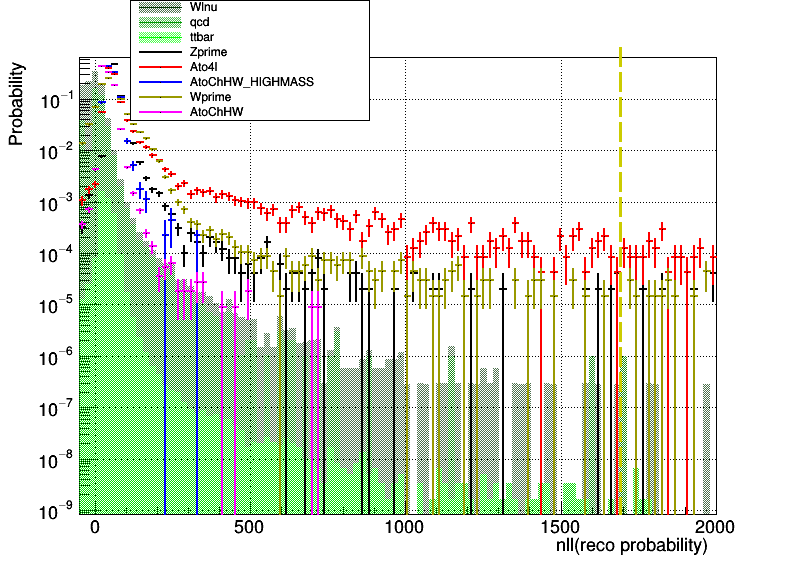

In [63]:
histos = []
loss_piece = 1
# binning = [50, np.min(loss_test[loss_piece]), np.max(loss_test[loss_piece])]
binning = [100, np.min(loss_test[loss_piece]), 2000]

c = rt.TCanvas('c', 'c', 800, 600)

for i in range(len(w_test)):
    h = rt.TH1F('h_loss_SM{}'.format(i), samples_name[i], binning[0], binning[1], binning[2])
    for j in range(i, len(w_test)):
        z = loss_test[loss_piece][y_test == j]
        h_tmp = rt.TH1F('h_tmp{}_{}'.format(i, j), samples_name[i], binning[0], binning[1], binning[2])
        rtnp.fill_hist(h_tmp, z)
        h.Add(h_tmp, w_test[samples_name[j]])
    
    h.SetStats(0)
    h.SetLineColor(rt.kGreen+4-2*i)
    h.SetFillColorAlpha(rt.kGreen+4-2*i, 0.7)
    h.SetFillStyle(3001)
    h.Draw('Bar SAME')
    histos.append(h)
    

tot = histos[0].Integral()
cumsum = tot
print tot*(1-1e-6)
N = histos[0].GetNbinsX()
while cumsum>tot*(1-1e-6):
    cumsum -= histos[0].GetBinContent(N)
    print cumsum
    N -= 1
N+=1
val_to_cut = histos[0].GetBinLowEdge(N)
print val_to_cut




    
colors = [1,2,4,rt.kYellow+2,6,7]
# fill
for i, n in enumerate(x_sig.keys()):
    h = rt.TH1F('h_loss_BSM{}'.format(i), n, binning[0], binning[1], binning[2])
    z = loss_sig[n][loss_piece]
    rtnp.fill_hist(h, z)
    h.Scale(1./float(z.shape[0]))

    h.SetStats(0)
    h.SetLineColor(colors[i])
    h.SetLineWidth(2)
    h.Draw('SAME')
    histos.append(h)
    print n, ': {:1.2e}'.format(np.sum(z>val_to_cut)/float(z.shape[0]))

c.BuildLegend()
histos[0].SetTitle('')
Ytitles = ['tot', 'nll(reco probability)', 'KL divergence']
histos[0].SetXTitle(Ytitles[loss_piece])
histos[0].SetYTitle('Probability')

line = rt.TLine()
line.SetLineColor(rt.kYellow+1)
line.SetLineWidth(3)
line.SetLineStyle(9)
line.DrawLine(val_to_cut,0, val_to_cut,1)

c.SetGrid()
c.SetLogy()
c.Draw()